#Libraries and data

In [ ]:
!pip install pmdarima

In [1]:
%cd D://Flood Risk Churn-MF/Evaluacion del dataset 25001 para validacion de articulo/25001

D:\Flood Risk Churn-MF\Evaluacion del dataset 25001 para validacion de articulo\25001


C:\Users\ZM\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [38]:
#import libraries
import numpy as np
import pandas as pd

In [2]:
#import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth']=1.5
dark_style={
 'figure.facecolor':'#212946',
 'axes.facecolor':'#212946',
 'savefig.facecolor':'#212946',
 'axes.grid':True,
 'axes.grid.which':'both',
 'axes.spines.top':False,
 'axes.spines.bottom':False,
 'grid.color':'#2A3459',
 'grid.linewidth':'1',
 'text.color':'0.9',
 'axes.labelcolor':'0.9',
 'xtick.color':'0.9',
 'ytick.color':'0.9',
 'font.size':12
}
plt.rcParams.update(dark_style)

In [3]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.tbats import TBATS
from sktime.utils.plotting import plot_series
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [4]:
#get the data
data = pd.read_csv("25001_61_71.csv",
                   index_col="FECHA",
                   parse_dates=True)
data.head(5)

,PRECIP,EVAP,TMAX,TMIN,FECHA_AUX
FECHA,,,,,
01/01/1961,1.0,5.0,25.0,13.0,01/01/1961
02/01/1961,1.0,5.0,27.5,14.0,02/01/1961
03/01/1961,1.0,5.0,31.0,11.0,03/01/1961
04/01/1961,1.0,5.0,32.0,13.0,04/01/1961
05/01/1961,1.0,5.0,29.0,14.0,05/01/1961


#Preparation

In [5]:
data.index = pd.to_datetime(data.index,
                            format = "%d/%m/%Y")
data.head(2)   
data = data.asfreq("MS")
data.index      

DatetimeIndex(['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01',
               ...
               '1971-03-01', '1971-04-01', '1971-05-01', '1971-06-01',
               '1971-07-01', '1971-08-01', '1971-09-01', '1971-10-01',
               '1971-11-01', '1971-12-01'],
              dtype='datetime64[ns]', name='FECHA', length=132, freq='MS')

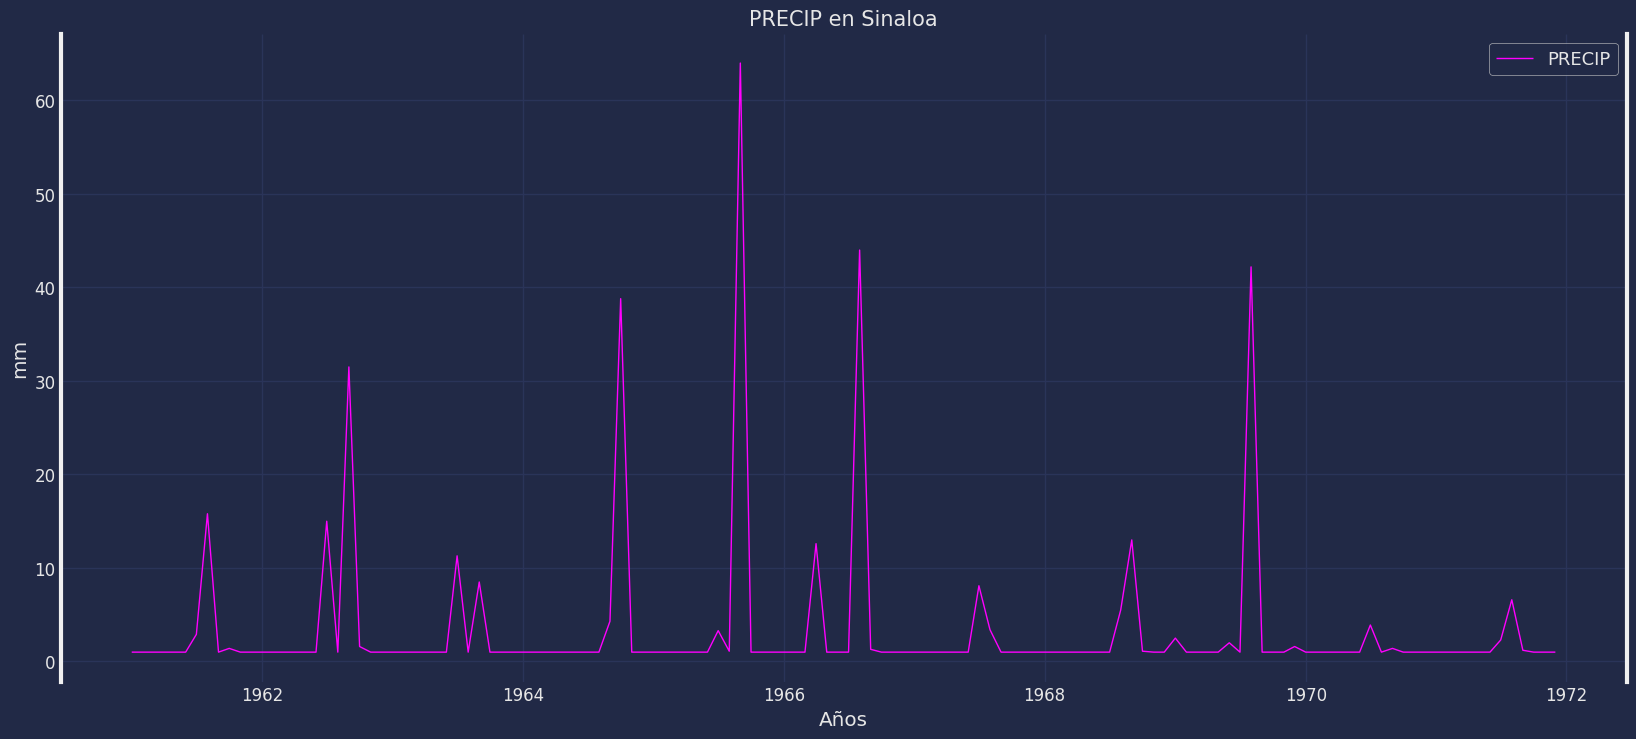

In [43]:
plt.figure(figsize=(18, 8))
plt.plot(data['PRECIP'],color="Magenta",linewidth=1)
plt.title('PRECIP en Sinaloa',fontsize=15)
plt.xlabel("Años")
plt.ylabel('mm')
plt.legend(['PRECIP'],fontsize=13)
plt.show()

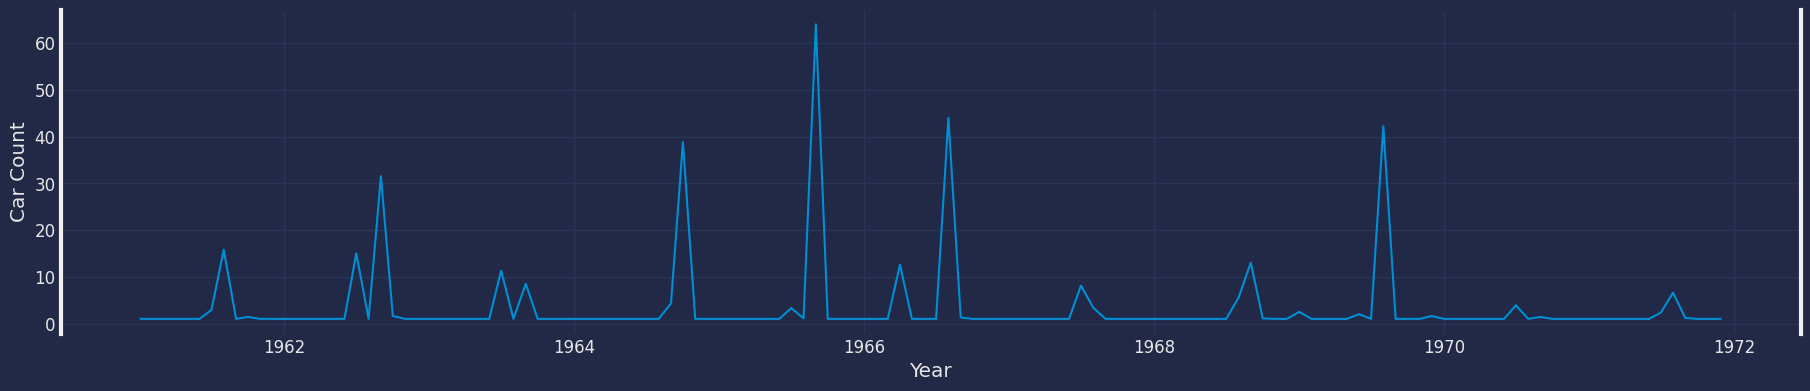

In [44]:
# plot car count over all years
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Year')
ax.set_ylabel('Car Count')
plt.plot(data.index, data['PRECIP']);  

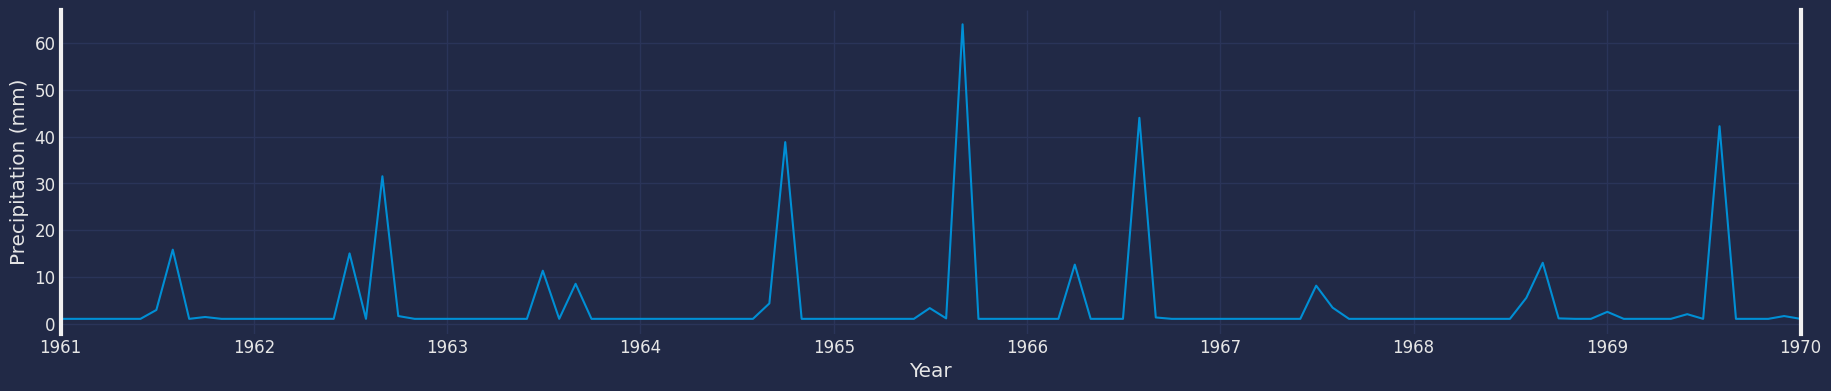

In [45]:
# car count for 2015
start = datetime.datetime(1961,1,1)
end = datetime.datetime(1970,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation (mm)')
plt.plot(data.index, data['PRECIP']);  

In [46]:
def metricas(y_true,y_pred,model_name):
    mae_=mean_absolute_error(y_true,y_pred)
    rmse_=mean_squared_error(y_true,y_pred,square_root=True)
    mape_=mean_absolute_percentage_error(y_true,y_pred)
    smape_=mean_absolute_percentage_error(y_true,y_pred,symmetric=True)
    dict_={'MAE':mae_,'RMSE_':rmse_,'MAPE':mape_,'SMAPE':smape_}
    metrica1=pd.DataFrame(dict_,index=[model_name])
    return(metrica1.round(decimals=2))

In [7]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train,y_test=temporal_train_test_split(data['TMAX'],test_size=36)
y_train1, y_test1=temporal_train_test_split(data['TMAX'],test_size=36)
y_train.head(10)
print('Training data shape: ', y_train.shape)
print('Test data shape: ', y_test.shape)

Training data shape:  (96,)
Test data shape:  (36,)


## Revisando Outliers

In [84]:
# Revisando estacionaridad
#test statistic is greater than critical value)
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print (df_results)

In [85]:
test_stationarity(data['PRECIP'])

Test Statistic           -2.411569
p-value                   0.138498
Lags                     10.000000
Observations            121.000000
Critical Value (1%)      -3.485585
Critical Value (5%)      -2.885739
Critical Value (10%)     -2.579676
dtype: float64


In [29]:
test_stationarity(data['TMAX'])

Test Statistic           -2.091682
p-value                   0.247873
Lags                     13.000000
Observations            118.000000
Critical Value (1%)      -3.487022
Critical Value (5%)      -2.886363
Critical Value (10%)     -2.580009
dtype: float64


In [30]:
test_stationarity(data['TMIN'])

Test Statistic           -1.946871
p-value                   0.310343
Lags                     11.000000
Observations            120.000000
Critical Value (1%)      -3.486056
Critical Value (5%)      -2.885943
Critical Value (10%)     -2.579785
dtype: float64


In [31]:
test_stationarity(data['EVAP'])

Test Statistic           -1.977683
p-value                   0.296443
Lags                     11.000000
Observations            120.000000
Critical Value (1%)      -3.486056
Critical Value (5%)      -2.885943
Critical Value (10%)     -2.579785
dtype: float64


#SARIMAX

In [88]:
#SARIMAX
from pmdarima import auto_arima
# Import packages
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox
model = auto_arima(x=y_train,y=y_train,m = 12,p=1,q=1, stepwise = True,order=(12, 1, 12))

print (model.summary())





                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 12)   Log Likelihood                -235.992
Date:                            Mon, 16 Sep 2024   AIC                            491.984
Time:                                    20:50:30   BIC                            517.628
Sample:                                01-01-1961   HQIC                           502.350
                                     - 12-01-1968                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     31.8157     29.956      1.062      0.288     -26.898      90.529
ar.L1         -0.7029      0.114   

In [89]:
#Predictions
predictions = pd.Series(model.predict(n_periods= 36,
                        x = y_train)).rename("SARIMAX")
predictions.head(10)

1969-01-01    30.523672
1969-02-01    32.004018
1969-03-01    34.148870
1969-04-01    34.768776
1969-05-01    36.906161
1969-06-01    37.369705
1969-07-01    36.094388
1969-08-01    35.244974
1969-09-01    34.615388
1969-10-01    34.839383
Freq: MS, Name: SARIMAX, dtype: float64

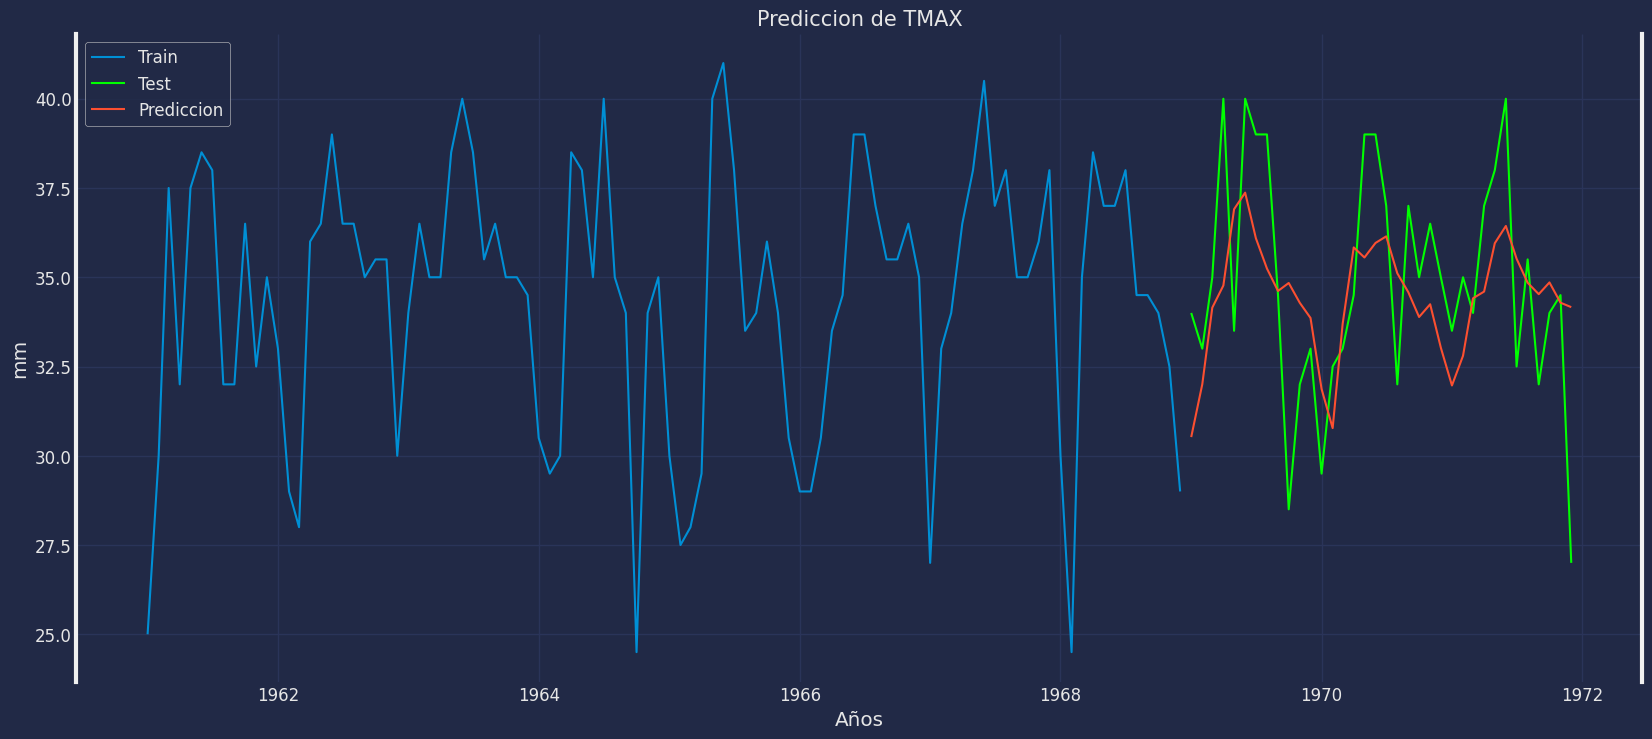

In [90]:
#Plotting

plt.figure(figsize=(18, 8))
plt.plot(y_train,label="Train")
plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
plt.plot(predictions,label="Prediccion")
plt.title("Prediccion de TMAX",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -2.4115688751682054, p-value: 0.13849776708785222
KPSS Statistic: 0.10871359451713557, p-value: 0.1

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -8.66941270999064, p-value: 4.589519561199627e-14
KPSS Statistic: 0.12214077473079034, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -8.999209338219574, p-value: 6.567000236182139e-15
KPSS Statistic: 0.07342096996669822, p-value: 0.1


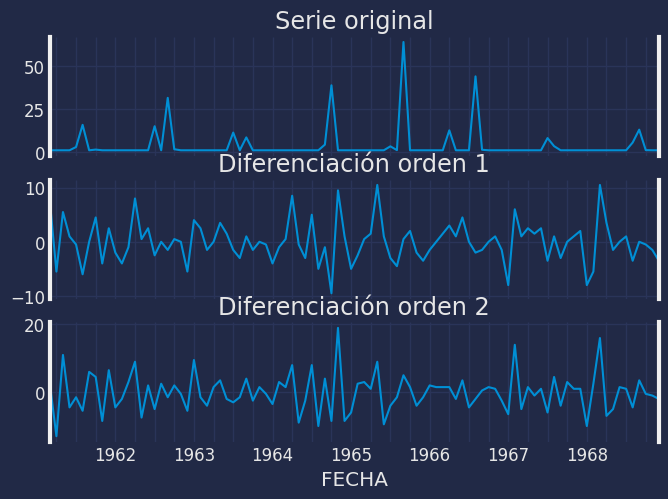

In [71]:
#Analisis de estacionariedad
# Import packages
# Import packages
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import kpss

datos_diff_1 = y_train.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(data['PRECIP'])
kpss_result = kpss(data['PRECIP'])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(data['PRECIP'].diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(data['PRECIP'].diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data['PRECIP'].plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = y_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               TMAX   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -213.403
Date:                            Mon, 16 Sep 2024   AIC                            436.806
Time:                                    21:05:04   BIC                            448.900
Sample:                                01-01-1961   HQIC                           441.665
                                     - 12-01-1968                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0744      0.166      0.447      0.655      -0.252       0.400
ma.L1         -0.8946      0.082    -10.936      0.000      -1.055      -0.734
ar.S.L12      -0.1754      0.182     -0.964      0.335      -0.532       0.181
ma.S.L12      -0.9987     54.034     -0.018      0.985    -106.903     104.905
sigma2         6.9305    373.628      0.019      0.985    -725.367     739.228
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                14.57
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.79
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(y_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

1969-01-01    29.352650
1969-02-01    30.662810
1969-03-01    31.329871
1969-04-01    34.044253
Freq: MS, Name: predicciones_statsmodels, dtype: float64

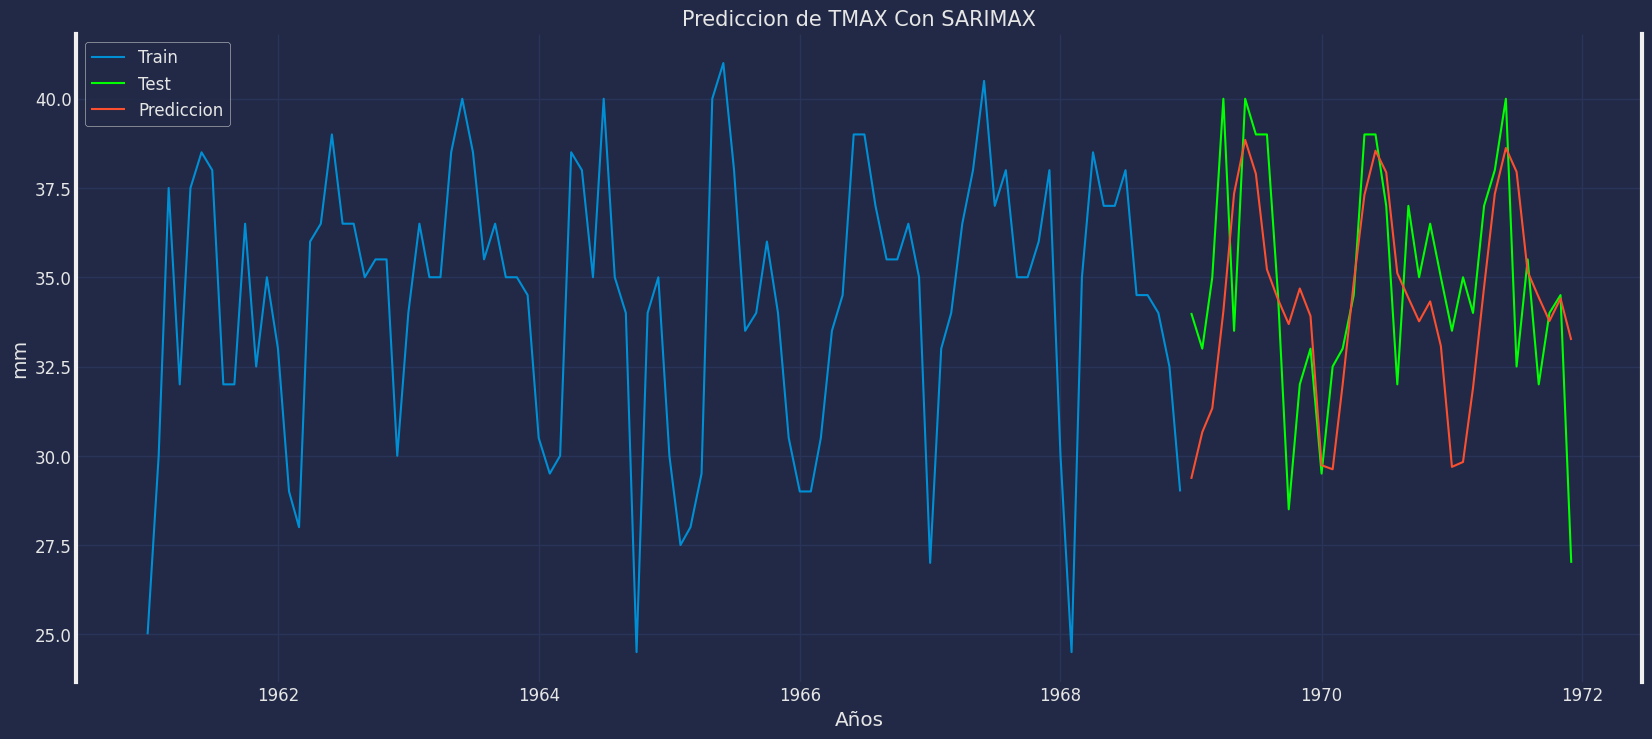

In [16]:
#Plotting

plt.figure(figsize=(18, 8))
plt.plot(y_train,label="Train")
plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
plt.plot(predicciones_statsmodels,label="Prediccion")
plt.title("Prediccion de TMAX Con SARIMAX",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

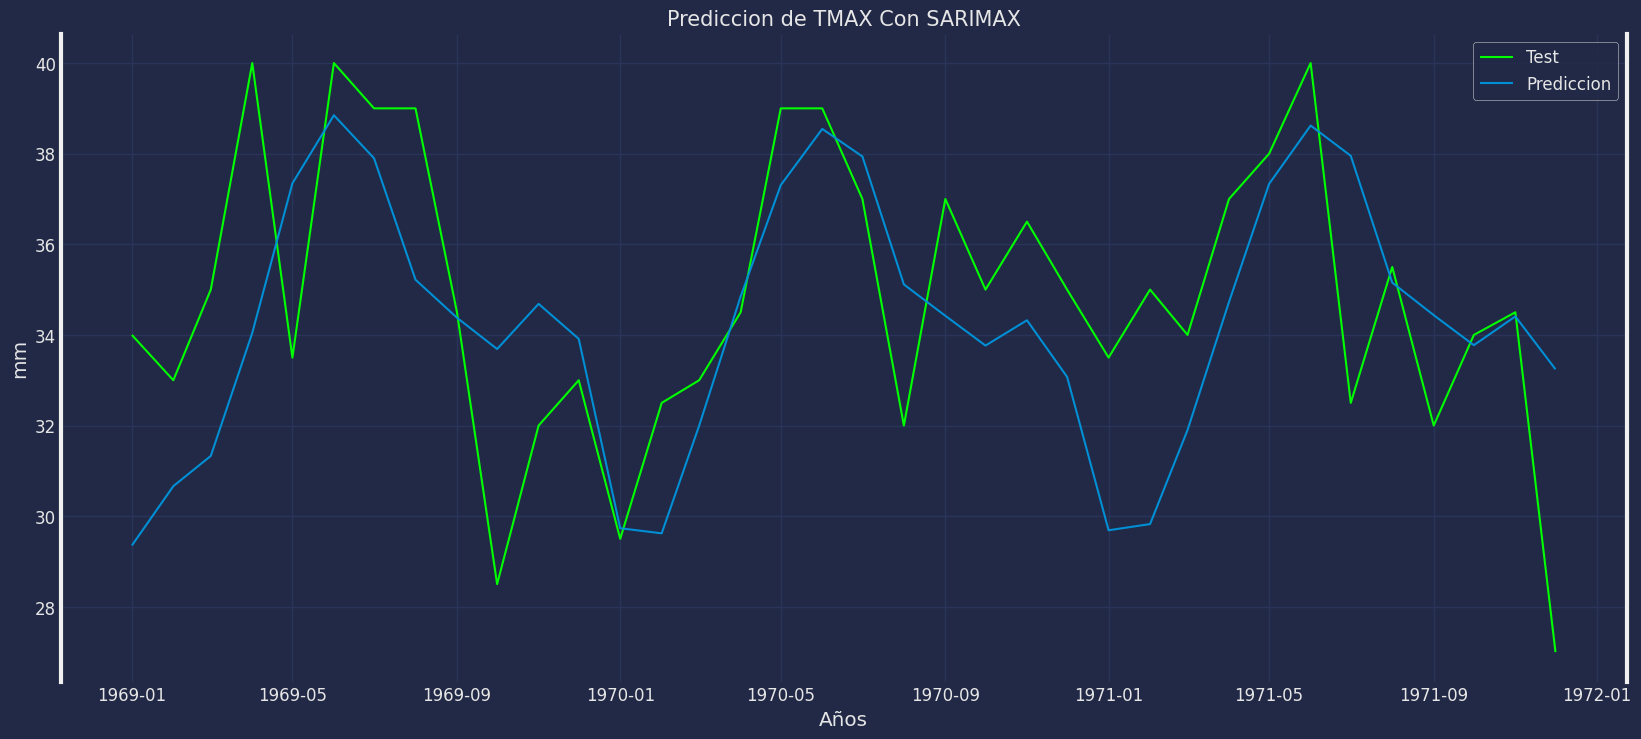

In [17]:
#Plotting

plt.figure(figsize=(18, 8))
plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
plt.plot(predicciones_statsmodels,label="Prediccion")
plt.title("Prediccion de TMAX Con SARIMAX",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

In [99]:
%pip install skforecast

Note: you may need to restart the kernel to use updated packages.Collecting skforecast
  Obtaining dependency information for skforecast from https://files.pythonhosted.org/packages/d8/b7/ee8344aa230a60b766d6dc8afa16535af4daf197d6e4912951d34fc2116e/skforecast-0.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for tqdm>=4.57 from https://files.pythonhosted.org/packages/48/5d/acf5905c36149bbaec41ccf7f2b68814647347b72075ac0b1fe3022fdc73/tqdm-4.66.5-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     --------------------- ------------------ 30.7/57.6 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 57.6/57.6 kB 1.5 MB/s eta 0:00:00
  Obtaining dependency information for optuna>=2.10 from https://files.pythonhosted.org/packages/4e/41/2a2f5ed6c997367ab7055185cf66d536c228b15a12b8e112a274808f48b5/optuna-4.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\ZM\AppData\Local\Programs\Python\Python311\Lib\threading.py:986: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  del self._target, self._args, self._kwargs
c:\Users\ZM\AppData\Local\Programs\Python\Python311\Lib\threading.py:986: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  del self._target, self._args, self._kwargs
c:\Users\ZM\AppData\Local\Programs\Python\Python311\Lib\threading.py:986: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  del self._target, self._args, self._kwargs


In [8]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
from skforecast.Sarimax import Sarimax
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=y_train)
modelo.summary()
warnings.filterwarnings("default")

In [9]:
# Predictión
# ==============================================================================
predicciones_skforecast = modelo.predict(steps=len(y_test))
display(predicciones_skforecast.head(4))

,pred
1969-01-01,29.352650
1969-02-01,30.662810
1969-03-01,31.329871
1969-04-01,34.044253


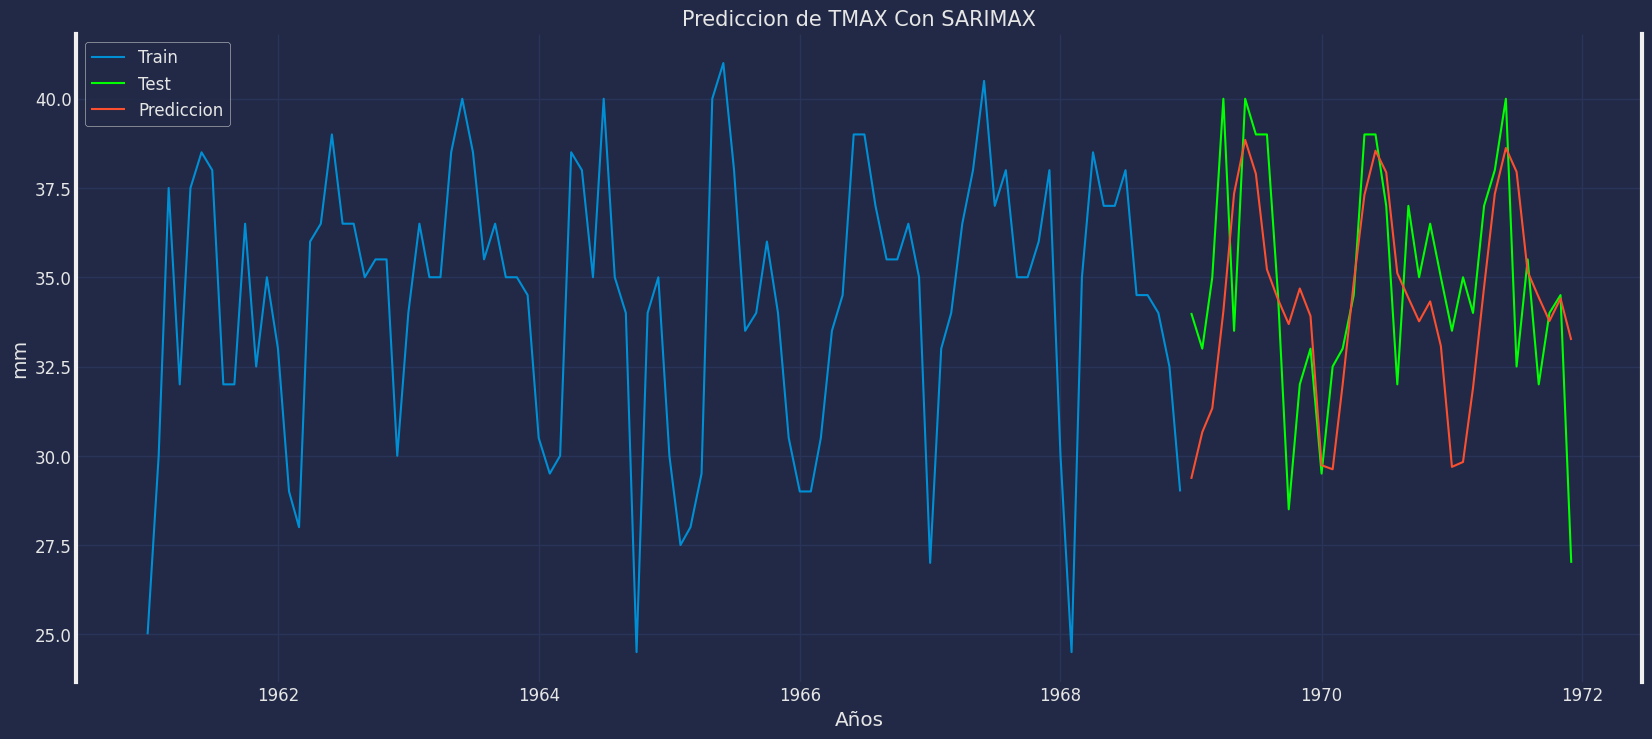

In [10]:
#Plotting

plt.figure(figsize=(18, 8))
plt.plot(y_train,label="Train")
plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
plt.plot(predicciones_skforecast,label="Prediccion")
plt.title("Prediccion de TMAX Con SARIMAX",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

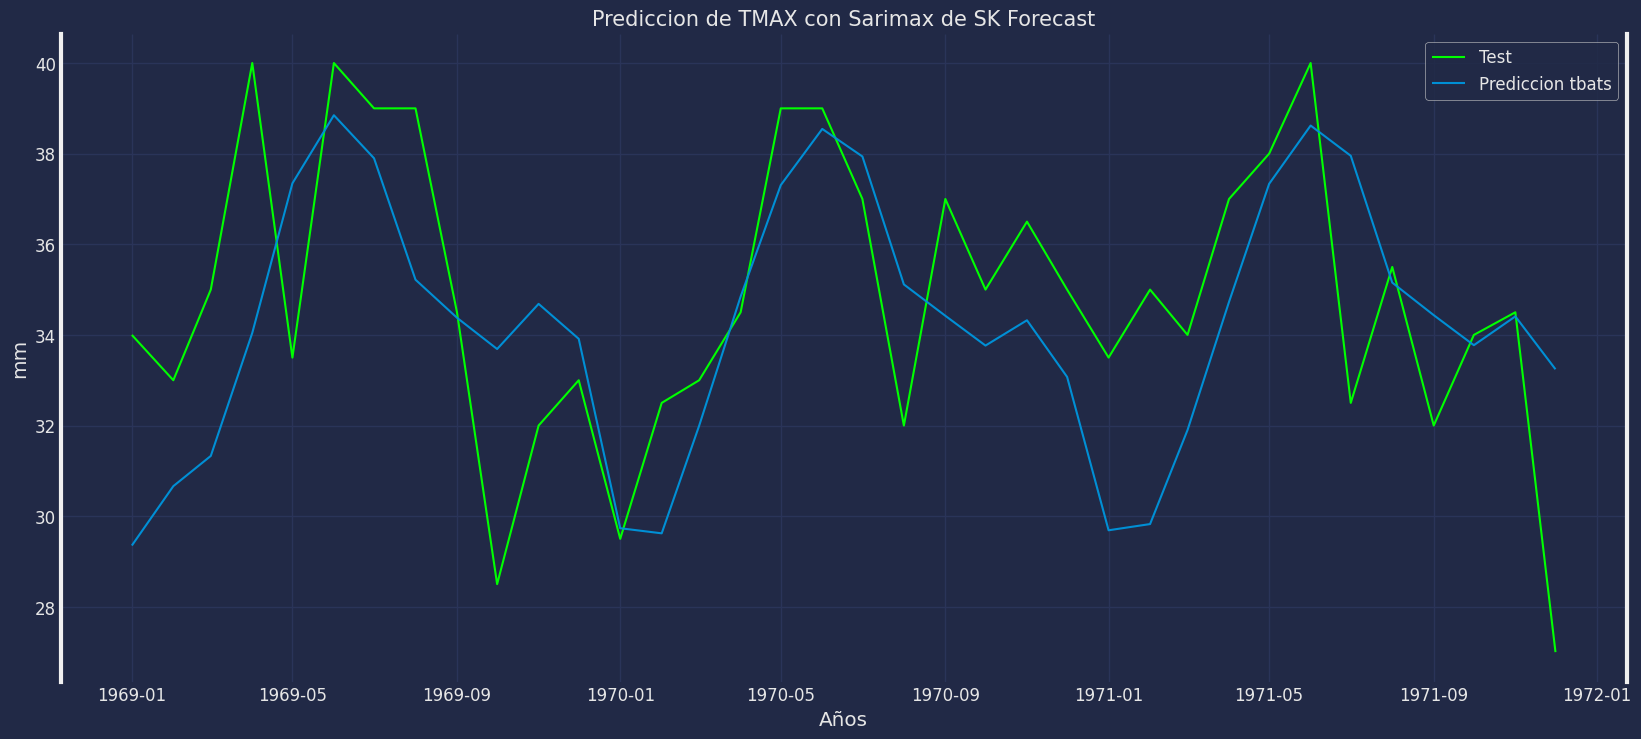

In [12]:
plt.figure(figsize=(18, 8))

plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
plt.plot(predicciones_skforecast,label="Prediccion tbats")
plt.title("Prediccion de TMAX con Sarimax de SK Forecast",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()